In [120]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import csv
import random
import glob
from tqdm.auto import tqdm
from PIL import Image
from skimage.color import rgb2hsv
import scipy.spatial
import fannypack as fp

In [184]:
raw_data = []
for path in tqdm(sorted(glob.glob("data/*.jpg"))):
    raw_data.append(mpimg.imread(path))

In [203]:
def load_dataset():
    # Load labels
    labels = []
    with open("data/labels.csv") as file:
        for i, row in enumerate(csv.reader(file)):
            tags = row[1]
            if "water" in tags:
                labels.append(True)
            # if "clear" in tags or "haze" in tags or "partly_cloudy" in tags:
            #     labels.append(True)
            else:
                labels.append(False)
    labels = np.array(labels)

    # Load images (with a progress bar!)
    data = np.array(raw_data)

    # Return
    print(f"Loaded {len(data)} images!")
    return {"data": data, "labels": labels}

In [204]:
dataset = load_dataset()

Loaded 2000 images!


In [205]:
# Balance dataset labels

true_indices = np.where(dataset["labels"])[0]
false_indices = np.where(np.logical_not(dataset["labels"]))[0]
mask = np.zeros(len(dataset["data"]), dtype=bool)

true_count = len(true_indices)
false_count = len(false_indices)
keep_count = min(true_count, false_count)

mask[true_indices[:keep_count]] = True
mask[false_indices[:keep_count]] = True

print(f"True count: {true_count}")
print(f"False count: {false_count}")
print(f"Keep count: {keep_count}")

dataset["data"] = dataset["data"][mask]
dataset["labels"] = dataset["labels"][mask]

True count: 363
False count: 1637
Keep count: 363


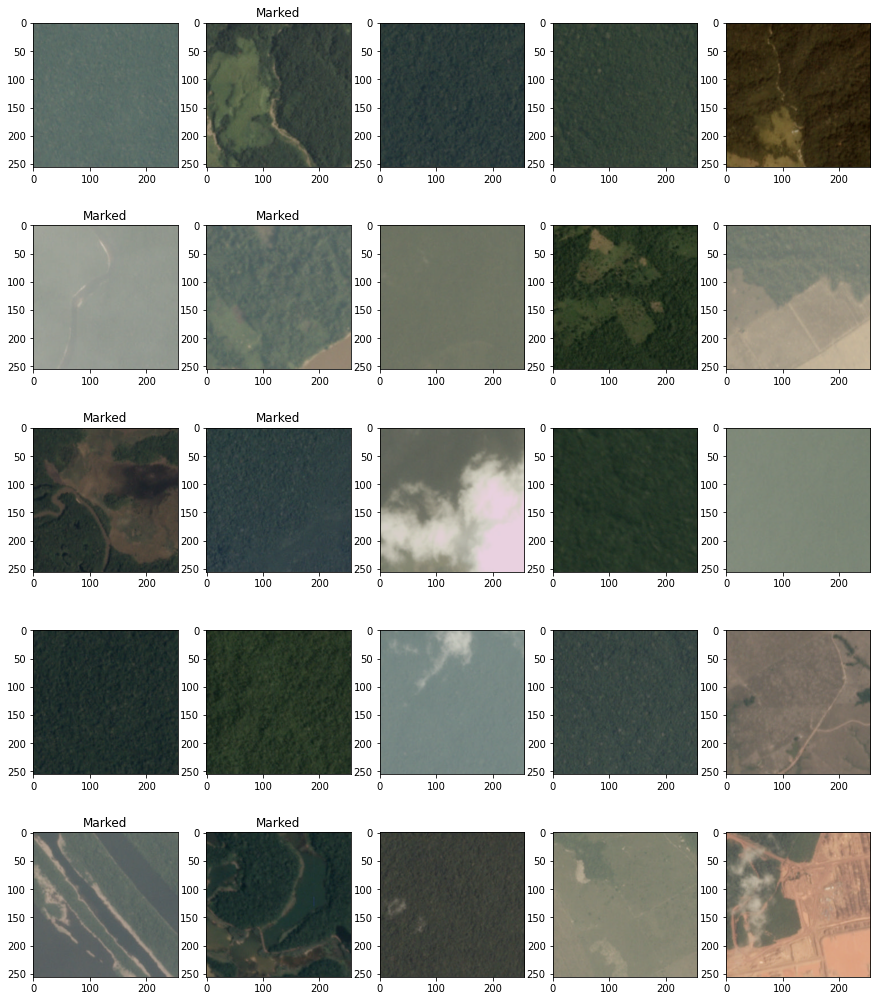

In [206]:
fig, axes = plt.subplots(5, 5, figsize=(15, 18))

for index, ax in enumerate(axes.flatten()):
    ax.imshow(dataset["data"][index])
    ax.set_title("Marked" if dataset["labels"][index] else "")

In [ ]:
# Compute features?
dataset["features"] = []
for image in tqdm(dataset["data"]):
    hsv = rgb2hsv(image[..., :3] / 255.0)
    features = np.mean(hsv.reshape(-1, 3), axis=0)
    dataset["features"].append(features)
dataset["features"] = np.array(dataset["features"])

In [189]:
dataset["labels"], dataset["features"], dataset["data"] = shuffle(
    dataset["labels"], dataset["features"], dataset["data"]
)

In [176]:
train_count = int(len(fp.utils.SliceWrapper(dataset)) * 0.8)

train_dataset = fp.utils.SliceWrapper(dataset)[:train_count]
val_dataset = fp.utils.SliceWrapper(dataset)[train_count:]

In [177]:
def eval_knn(eval_dataset, k=5):
    samples = eval_dataset["features"]
    labels = eval_dataset["labels"]
    train_samples = train_dataset["features"]
    train_labels = train_dataset["labels"]

    distances = scipy.spatial.distance.cdist(samples, train_samples)
    assert distances.shape == (samples.shape[0], train_samples.shape[0])

    pred_labels = np.zeros_like(labels)
    confusion_matrix = np.zeros((2, 2), dtype=np.uint64)

    for i in range(len(samples)):
        closest_labels = train_labels[np.argsort(distances[i])[:k]]
        counts = np.bincount(closest_labels)
        pred_labels[i] = np.argmax(counts)
        
        confusion_matrix[int(labels[i]), int(pred_labels[i])] += 1

    print(confusion_matrix)
    return pred_labels

In [178]:
eval_knn(val_dataset)

[[51 28]
 [28 59]]


array([False,  True,  True, False, False, False,  True, False,  True,
       False, False,  True, False, False, False,  True,  True, False,
        True, False,  True,  True, False,  True, False, False,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
       False, False,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True,  True, False, False, False,  True,
       False, False, False, False,  True,  True, False, False, False,
       False,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True, False,  True,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
        True, False,  True,  True,  True, False, False, False,  True,
       False,  True, False,  True, False,  True, False, False, False,
        True, False,  True,  True, False, False,  True, False,  True,
       False,  True,